<a href="https://colab.research.google.com/github/Barissdal/Cohort-Analysis/blob/main/Cohort_Analysis_Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Reading Data from Excel

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

df_ = pd.read_excel("/content/drive/MyDrive/resource/online_retail_II.xlsx",sheet_name="Year 2010-2011")

df = df_.copy()

In [63]:
# Eksik gözlemlerin silinmesi
df.dropna(inplace=True)

In [64]:
# İade edilen ürünlerin silinmesi
df = df[~df["Invoice"].str.contains("C", na=False)]

In [65]:
#Quantity ve Price değerlerinde 0dan küçük olanların silinmesi

df = df[(df['Quantity'] > 0)]
df = df[(df['Price'] > 0)]

In [66]:
#TotalPrice değişkenin hesaplanması
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [71]:
df = df.rename(columns={'Customer ID': 'CustomerID'})

In [67]:
def monthly(x):
    return dt.datetime(x.year, x.month, 1)

In [68]:
df['BillMonth'] = df['InvoiceDate'].apply(monthly)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397885 entries, 0 to 541909
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      397885 non-null  object        
 1   StockCode    397885 non-null  object        
 2   Description  397885 non-null  object        
 3   Quantity     397885 non-null  int64         
 4   InvoiceDate  397885 non-null  datetime64[ns]
 5   Price        397885 non-null  float64       
 6   CustomerID   397885 non-null  float64       
 7   Country      397885 non-null  object        
 8   TotalPrice   397885 non-null  float64       
 9   BillMonth    397885 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 33.4+ MB


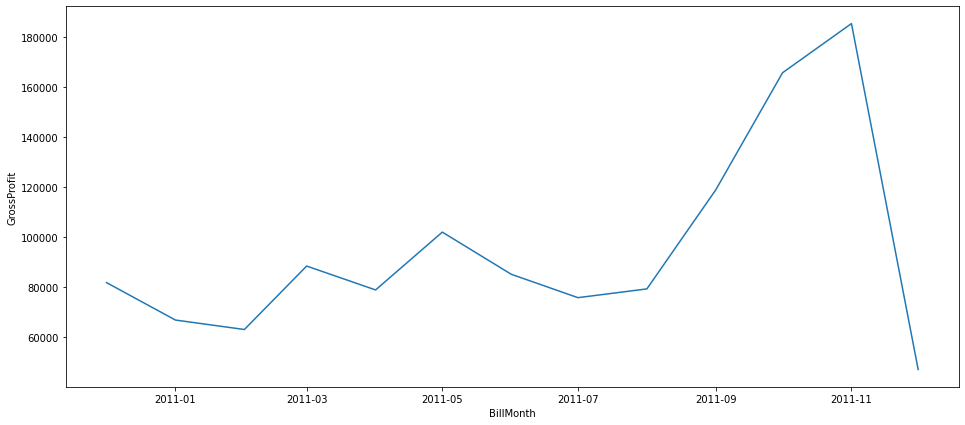

In [78]:
df_sum = df.groupby('BillMonth').sum().drop('CustomerID', axis = 1)
df_sum = df_sum.rename(columns={'Price' : 'GrossProfit'})

plt.figure(figsize=(16,7))
sns.lineplot(x = df_sum.index, y = df_sum['GrossProfit'])
plt.show()

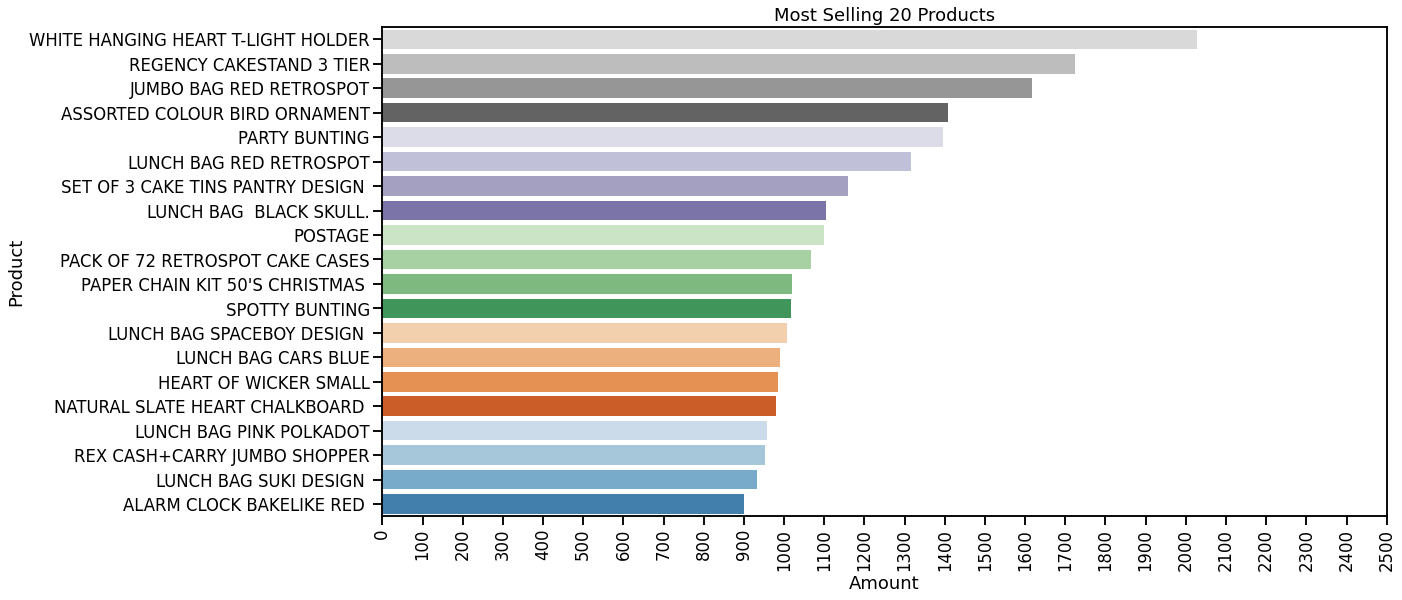

In [79]:
most_selling_products = df['Description'].value_counts()[:20]
plt.figure(figsize = (18,9))
sns.set_context("talk")
sns.barplot(x = most_selling_products.values, y = most_selling_products.index,palette = "tab20c_r")
plt.xticks(np.arange(0,2501,100),rotation = 90)
plt.xlabel("Amount")
plt.ylabel("Product")
plt.title("Most Selling 20 Products")

plt.show()

In [80]:
g = df.groupby('CustomerID')['BillMonth']
df['CohortMonth'] = g.transform('min')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice,BillMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01


In [ ]:
def get_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

In [82]:
billYear, billMonth = get_int(df, 'BillMonth')
cohortYear, cohortMonth = get_int(df, 'CohortMonth')

In [83]:
diffYear = billYear - cohortYear
diffMonth = billMonth - cohortMonth

In [84]:
df['Month_Index'] = diffYear * 12 + diffMonth + 1

In [85]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice,BillMonth,CohortMonth,Month_Index
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1


In [ ]:
df['CohortMonth'] = df['CohortMonth'].apply(dt.datetime.date)

In [87]:
g = df.groupby(['CohortMonth', 'Month_Index'])

In [88]:
cohortData = g['CustomerID'].apply(pd.Series.nunique).reset_index()
cohortCounts = cohortData.pivot(index = 'CohortMonth', columns = 'Month_Index', values = 'CustomerID')
cohortSizes = cohortCounts.iloc[:, 0]
retention = cohortCounts.divide(cohortSizes, axis = 0) * 100

In [95]:
cohortCounts.head()

Month_Index,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN


In [89]:
retention.round(2)

Month_Index,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.61,32.32,38.42,36.27,39.77,36.27,34.92,35.37,39.55,37.40,50.28,26.55
2011-01-01,100.0,22.06,26.62,23.02,32.13,28.78,24.70,24.22,29.98,32.61,36.45,11.75,NaN
2011-02-01,100.0,18.68,18.68,28.42,27.11,24.74,25.26,27.89,24.74,30.53,6.84,NaN,NaN
2011-03-01,100.0,15.04,25.22,19.91,22.35,16.81,26.77,23.01,27.88,8.63,NaN,NaN,NaN
2011-04-01,100.0,21.33,20.33,21.00,19.67,22.67,21.67,26.00,7.33,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.01,17.25,17.25,20.77,23.24,26.41,9.51,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.36,15.70,26.45,23.14,33.47,9.50,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.09,20.74,22.34,27.13,11.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.71,24.85,24.26,12.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


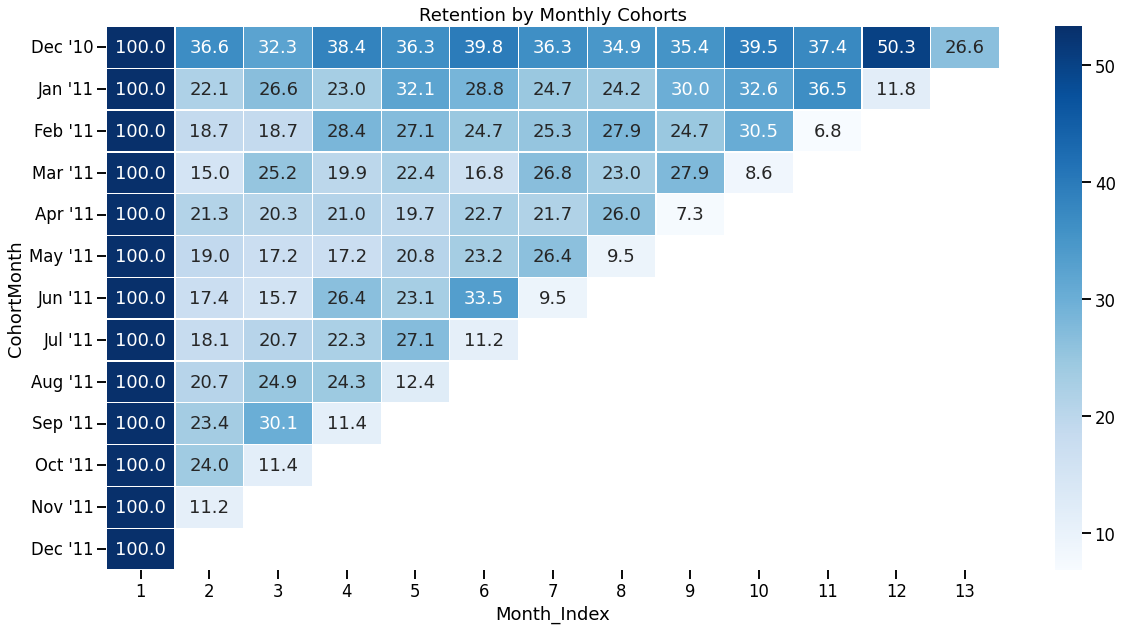

In [94]:
month_list = ["Dec '10", "Jan '11", "Feb '11", "Mar '11", "Apr '11", "May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11", "Oct '11", "Nov '11", "Dec '11"]
plt.figure(figsize = (20,10))
plt.title('Retention by Monthly Cohorts')
sns.heatmap(retention.round(2), annot = True, cmap = "Blues", vmax = list(retention.max().sort_values(ascending = False))[1]+3, fmt = '.1f', linewidth = 0.3, yticklabels=month_list)
plt.show()

In [96]:
#Cohort Revenue
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice,BillMonth,CohortMonth,Month_Index
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1


In [97]:
user_cohorts= df.iloc[:,[6,10]]
#user_cohorts.columns = ['customerId','cohortMonth']

In [104]:
order_month = df.iloc[:,[6,8,9,10,11]]

In [105]:
order_month.head()

,CustomerID,TotalPrice,BillMonth,CohortMonth,Month_Index
0,17850.0,15.30,2010-12-01,2010-12-01,1
1,17850.0,20.34,2010-12-01,2010-12-01,1
2,17850.0,22.00,2010-12-01,2010-12-01,1
3,17850.0,20.34,2010-12-01,2010-12-01,1
4,17850.0,20.34,2010-12-01,2010-12-01,1


In [106]:
order_month=order_month.groupby(['CustomerID','Month_Index'])['TotalPrice'].sum().reset_index()
order_month.columns =['customerId','monthNumber','revenue']
order_month.head()

,customerId,monthNumber,revenue
0,12346.0,1,77183.60
1,12347.0,1,711.79
2,12347.0,2,475.39
3,12347.0,5,636.25
4,12347.0,7,382.52


In [107]:
#cohort_size = pd.merge(df,user_cohorts, on="customerId", how="left")
#cohort_size['created_at'] = pd.to_datetime(cohort_size['created_at'])
cohort_size=df.groupby('BillMonth')['TotalPrice'].sum().reset_index()
cohort_size.head()

,BillMonth,TotalPrice
0,2010-12-01,572713.890
1,2011-01-01,569445.040
2,2011-02-01,447137.350
3,2011-03-01,595500.760
4,2011-04-01,469200.361


In [108]:
retention_table=df.groupby(['BillMonth','Month_Index'])['TotalPrice'].sum().reset_index()
retention_table.columns =['BillMonth','monthNumber','revenue']
retention_table.head()

,BillMonth,monthNumber,revenue
0,2010-12-01,1,572713.89
1,2011-01-01,1,293207.35
2,2011-01-01,2,276237.69
3,2011-02-01,1,158142.07
4,2011-02-01,2,55149.91


In [114]:
cohort_ltv=pd.merge(retention_table,cohort_size, on='BillMonth',how='left')
bool_series=pd.notnull(cohort_ltv["BillMonth"])
cohort_ltv=cohort_ltv[bool_series]
cohort_ltv.head()

,BillMonth,monthNumber,revenue,TotalPrice
0,2010-12-01,1,572713.89,572713.89
1,2011-01-01,1,293207.35,569445.04
2,2011-01-01,2,276237.69,569445.04
3,2011-02-01,1,158142.07,447137.35
4,2011-02-01,2,55149.91,447137.35


In [115]:
cohort_ltv['percentage'] = (cohort_ltv['revenue'] / cohort_ltv['TotalPrice'])
cohort_ltv.head()

,BillMonth,monthNumber,revenue,TotalPrice,percentage
0,2010-12-01,1,572713.89,572713.89,1.000000
1,2011-01-01,1,293207.35,569445.04,0.514900
2,2011-01-01,2,276237.69,569445.04,0.485100
3,2011-02-01,1,158142.07,447137.35,0.353677
4,2011-02-01,2,55149.91,447137.35,0.123340


In [116]:
cohort_ltv=cohort_ltv.iloc[:,[0,1,3,4]]
cohort_ltv.columns=['purchaseMonth','monthNumber','total_revenue','percentage']

In [118]:
cohort_ltv_pivot=cohort_ltv.pivot_table(index='purchaseMonth', columns='monthNumber', values='percentage')
cohort_ltv_pivot.head()

monthNumber,1,2,3,4,5,6,7,8,9,10,11,12,13
purchaseMonth,,,,,,,,,,,,,
2010-12-01,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01,0.514900,0.485100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-01,0.353677,0.123340,0.522983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-01,0.335969,0.048771,0.106244,0.509016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-01,0.260041,0.064065,0.087669,0.152573,0.435651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


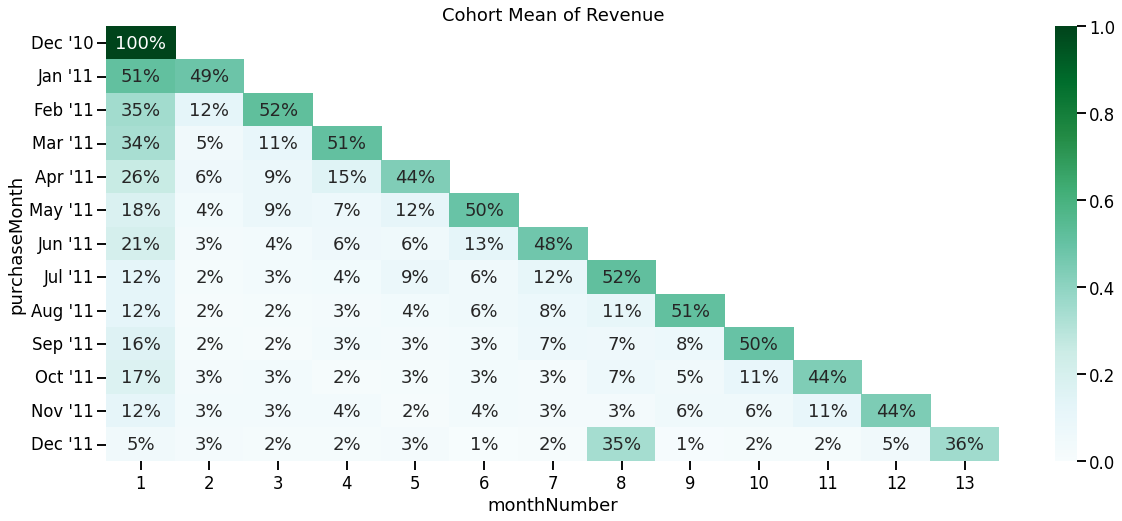

In [123]:
plt.figure(figsize=(20,8))
month_list = ["Dec '10", "Jan '11", "Feb '11", "Mar '11", "Apr '11", "May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11", "Oct '11", "Nov '11", "Dec '11"]
plt.title("Cohort Mean of Revenue")
sns.heatmap(data=cohort_ltv_pivot,
           annot=True,
           fmt='.0%',
           vmin=0.0,
           vmax=1,
           cmap="BuGn",
           yticklabels=month_list)
plt.show()